In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


team_size = 10
pos_size = {'QB': 1, 'WR': 2, 'RB': 2, 'TE': 1}
pd.set_option('display.max.rows', 500)
pd.set_option('display.max.columns', 25)

#reads rankings from human fantasy exerts
df = pd.read_csv("Rankings2022.csv", index_col="PLAYER NAME", usecols= ["RK","PLAYER NAME", "TEAM", "POS"])

#reads fantasy per game stats from selected years stores them in a dictionary
years = range(2018,2023)
stats = {year: pd.read_csv("Stats" + str(year) + ".csv", index_col="PLAYER NAME").fillna(0) for year in years}

#categories of data contained in csv
categories = ["GS","PassYds","PassTD","Int","RushAtt","RushYds","Y/A","RushTD","Tgt","Rec","RecYds","RecTD","FL","TD","PPR","VBD"]

#function to return fantasy scoring data of specified years. Use pos to specific position group, logic to determine if
#player has to have played in all years specifiedk, and decay create a weighted scoring average emphasizing the most recent years
def get_stat(start, end=None, pos="", logic='outer', decay=1):
    total = None
    #checks proper year ranges are inserted
    if start in years and end in years and start < end:
        #merges first two years of data
        total = stats[start].merge(stats[start+1], on="PLAYER NAME", how=logic, suffixes= ("_first", "_second")).fillna(0)
        while True:
            #operations to combine per game data of the two year
            for info in ["TEAM", "POS", "Age"]:
                total[info] = np.where(total[info + "_second"]!=0, total[info + "_second"], total[info + "_first"])

            total["G"] = total['G_first'] + total['G_second']

            for category in categories:
                total[category] = (total['G_first'] * total[category + "_first"] * decay + total['G_second'] * total[category + "_second"]) / (total['G_first'] * decay + total['G_second'])

            total.drop(total.filter(regex="(_first|_second)$"), axis=1, inplace = True)
            start += 1
            #checks if more years of data should be combined
            if start < end: 
                total = total.merge(stats[start+1],on="PLAYER NAME", how=logic, suffixes= ("_first", "_second")).fillna(0)
            else:
                break
    elif start in years and not end:
        total = stats[start]
    
    if isinstance(total, pd.DataFrame):
        if pos and pos.upper() in ["RB", "WR", "QB", "TE"]:
            filter = total["POS"].str.contains(pos.upper()).fillna(False)
            total = total.loc[filter]
    
    return total.sort_values(by="PPR", ascending=False)


#function to plot data of specified player over a 5 year span, VOR = Value over Replacement, which graphs the performance of 
#a typical backup
def plot_player(names, stat, VOR=False):


    fig, ax = plt.subplots()
    #plots data for each player named 
    pos_list = []
    for name in names:
        x = []
        y = []
        pos = None
        #gathers stats for each year player has played
        for year in stats.items():
            try:
                if VOR and pos == None:
                    pos = year[1].loc[name]["POS"]
                    if pos not in pos_list:
                        pos_list.append(pos)
                y.append(year[1].loc[name][stat])
                x.append(year[0])
            except KeyError:
                pass
        
        #convert data gathered to data frame
        player_data = pd.DataFrame(y, index = x)

        #compute exponential moving average of data 
        ema = player_data.ewm(com= 0.6).mean()
        
                


        #plots data points and exponential moving average
        p = ax.plot(player_data, label = name)
        ax.plot(ema, color= p[-1].get_color(), ls = ":", lw =1)

    for pos in pos_list:
        VORx = []
        VORy = []
        #compute VOR 
        for year, df in stats.items():
            filter = df["POS"].str.contains(pos).fillna(False)
            df = df.loc[filter]
            replacement_index = team_size * pos_size[pos]
            df = df.sort_values(by=stat, ascending=False).iloc[replacement_index: replacement_index + team_size]

            VORx.append(year)
            VORy.append(round((df[stat].sum()/team_size), 2))

        VOR_data = pd.DataFrame(VORy, index=VORx)

        ax.plot(VOR_data, label = pos + " replacement")
    #sets x axis to be increments of one year
    loc = plt.MultipleLocator(base=1.0) 
    ax.xaxis.set_major_locator(loc)
    ax.set_ylim(bottom=0)
    
    #labels graphs
    plt.xlabel("Year")
    plt.ylabel(stat)
    title = " vs. ".join(names)
    plt.title(title)
    plt.legend()

    plt.show()


#sample usage of get_stat

display(get_stat(2018, pos="RB").head(12))

display(get_stat(2019, 2022, logic='inner').head(12))



,TEAM,POS,Age,G,GS,PassYds,PassTD,Int,RushAtt,RushYds,Y/A,RushTD,Tgt,Rec,RecYds,RecTD,FL,TD,PPR,VBD
PLAYER NAME,,,,,,,,,,,,,,,,,,,,
Todd Gurley,LAR,RB,24,14,14,0.00,0.00,0.0,18.30,89.4,4.89,1.21,5.79,4.21,41.4,0.29,0.07,1.50,26.6,12.70
Saquon Barkley,NYG,RB,21,16,16,0.00,0.00,0.0,16.30,81.7,5.01,0.69,7.56,5.69,45.1,0.25,0.00,0.94,24.1,9.94
Christian McCaffrey,CAR,RB,22,16,16,3.13,0.06,0.0,13.70,68.6,5.01,0.44,7.75,6.69,54.2,0.38,0.06,0.81,24.1,8.94
Alvin Kamara,NOR,RB,23,15,13,0.00,0.00,0.0,12.90,58.9,4.55,0.93,7.00,5.40,47.3,0.27,0.00,1.20,23.6,9.20
Melvin Gordon,LAC,RB,25,12,12,0.00,0.00,0.0,14.60,73.8,5.06,0.83,5.50,4.17,40.8,0.33,0.00,1.17,23.0,7.50
Ezekiel Elliott,DAL,RB,23,15,15,0.00,0.00,0.0,20.30,95.6,4.72,0.40,6.33,5.13,37.8,0.20,0.07,0.60,21.9,7.80
James Conner,PIT,RB,23,13,12,0.00,0.00,0.0,16.50,74.8,4.53,0.92,5.46,4.23,38.2,0.08,0.15,1.00,21.5,6.92
Kareem Hunt,KAN,RB,23,11,11,0.00,0.00,0.0,16.50,74.9,4.55,0.64,3.18,2.36,34.4,0.64,0.00,1.27,20.9,6.27
Joe Mixon,CIN,RB,22,14,13,0.00,0.00,0.0,16.90,83.4,4.93,0.57,3.93,3.07,21.1,0.07,0.00,0.64,17.4,4.64


,TEAM,POS,Age,G,GS,PassYds,PassTD,Int,RushAtt,RushYds,Y/A,RushTD,Tgt,Rec,RecYds,RecTD,FL,TD,PPR,VBD
PLAYER NAME,,,,,,,,,,,,,,,,,,,,
Christian McCaffrey,2TM,RB,26,43,13.627907,0.790698,0.023721,0.000000,16.023256,74.253488,4.635349,0.674884,7.210233,5.931163,52.048837,0.253488,0.000000,0.930000,24.304651,7.848372
Patrick Mahomes,KAN,QB,27,63,15.857143,299.339683,2.254286,0.571905,3.681270,20.085714,5.450952,0.159206,0.047143,0.016190,0.094444,0.000000,0.126825,0.159206,22.893651,5.380476
Josh Allen,BUF,QB,26,65,16.261538,251.126154,1.969846,0.739692,7.032308,37.786154,5.317077,0.460769,0.014769,0.014769,0.184615,0.014769,0.278462,0.475538,22.813846,5.859231
Lamar Jackson,BAL,QB,25,54,13.666667,203.861111,1.758333,0.646667,10.734444,69.300000,6.456111,0.354444,0.000000,0.000000,0.000000,0.000000,0.204444,0.354444,22.683333,3.730556
Davante Adams,LVR,WR,30,59,15.000000,0.000000,0.000000,0.000000,0.051864,-0.017288,-0.095085,0.000000,10.600000,7.135254,92.213559,0.814915,0.032881,0.814915,21.181356,5.527966
Kyler Murray,ARI,QB,25,57,14.543860,242.949123,1.473509,0.718947,6.683684,38.666667,5.756842,0.404386,0.000000,0.000000,0.122807,0.000000,0.141404,0.404386,20.442105,2.597193
Derrick Henry,TEN,RB,28,55,14.563636,0.164364,0.036364,0.000000,22.701818,109.856364,4.850182,1.017636,2.109091,1.600000,15.861455,0.035455,0.147636,1.053091,20.414545,8.547818
Dak Prescott,DAL,QB,29,49,13.897959,287.093878,2.022041,0.818776,3.326531,14.250612,4.250000,0.162449,0.020408,0.020408,0.224490,0.020408,0.247347,0.182857,20.251020,2.511020
Austin Ekeler,LAC,RB,27,59,13.101695,0.000000,0.000000,0.000000,11.159322,49.352542,4.411356,0.490847,6.679153,5.474746,46.872881,0.388644,0.138644,0.882373,20.171186,5.321695


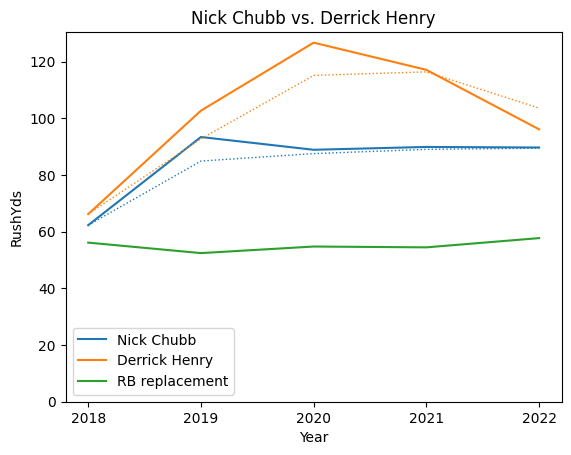

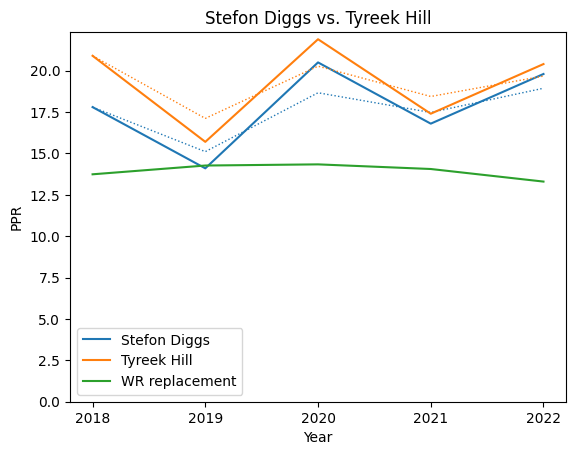

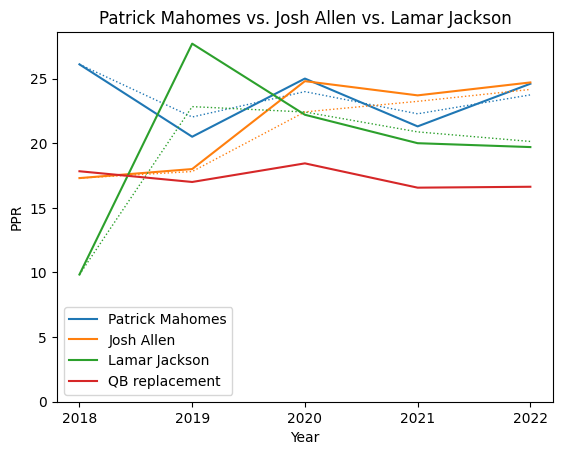

In [11]:
#sample usage of plot_player for research/comparision
plot_player(["Nick Chubb", "Derrick Henry"], "RushYds", VOR=True)
plot_player(["Stefon Diggs", "Tyreek Hill"], "PPR")
plot_player(["Patrick Mahomes", "Josh Allen", "Lamar Jackson"], "PPR", VOR=True)